<a href="https://colab.research.google.com/github/ThomasKarabo/Credit-Risk-Model/blob/main/Credit_Modelling_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

## 1. Data Cleaning

In [2]:
def wrangle(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Remove outliers
    df = df[(df['person_income'] < 1000000) & (df['loan_int_rate'] < 100) & (df['person_age'] < 120) & (df['person_emp_length'] < 40)]

    # Encode the loan status column
    df['loan_status'] = df['loan_status'].astype(bool)

    return df

In [3]:
df = wrangle('/content/sample_data/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,False,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,True,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,True,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,True,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,True,0.25,N,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28625 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28625 non-null  int64  
 1   person_income               28625 non-null  int64  
 2   person_home_ownership       28625 non-null  object 
 3   person_emp_length           28625 non-null  float64
 4   loan_intent                 28625 non-null  object 
 5   loan_grade                  28625 non-null  object 
 6   loan_amnt                   28625 non-null  int64  
 7   loan_int_rate               28625 non-null  float64
 8   loan_status                 28625 non-null  bool   
 9   loan_percent_income         28625 non-null  float64
 10  cb_person_default_on_file   28625 non-null  object 
 11  cb_person_cred_hist_length  28625 non-null  int64  
dtypes: bool(1), float64(3), int64(4), object(4)
memory usage: 2.6+ MB


It seems that we do have some Nan values but only in numerical columns, this makes things easier because we can impute the values instead of dropping them.

## 2. Data Exporation and Visualization

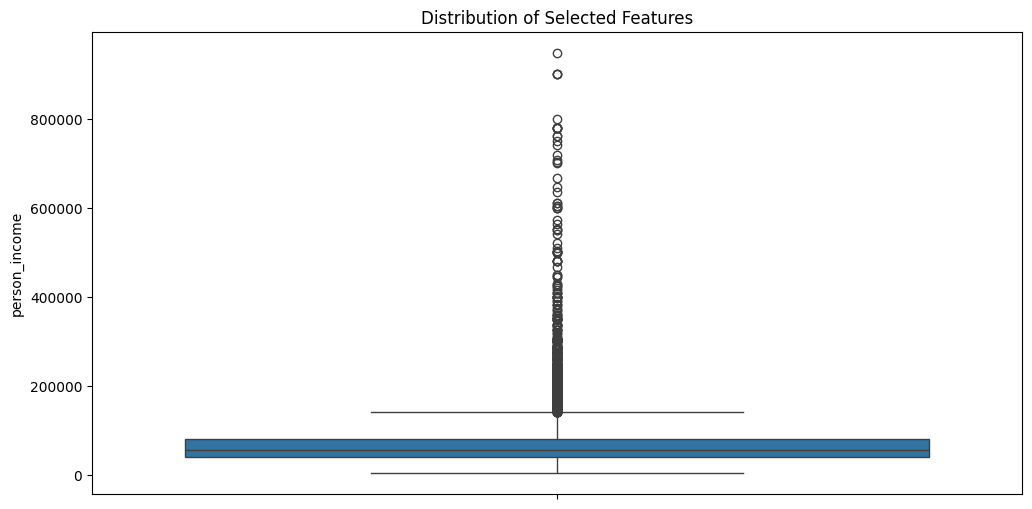

In [5]:
cols = 'person_income'
df_selected = df[cols]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_selected)
plt.title('Distribution of Selected Features')
plt.xticks(rotation=45)
plt.show()

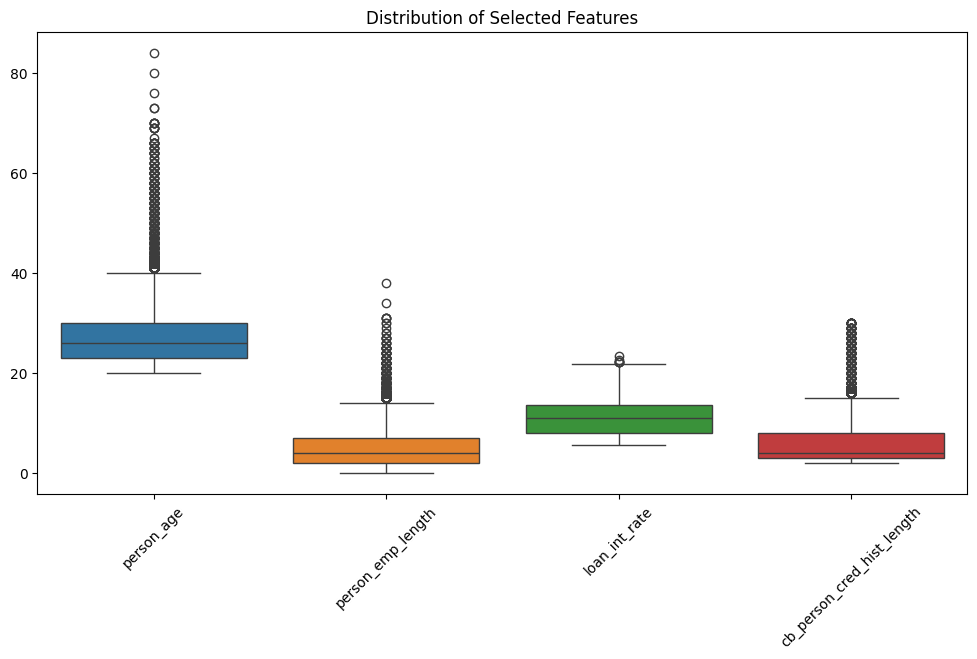

In [6]:
cols = ['person_age', 'person_emp_length','loan_int_rate','cb_person_cred_hist_length']
df_selected = df[cols]


plt.figure(figsize=(12, 6))
sns.boxplot(data=df_selected)
plt.title('Distribution of Selected Features')
plt.xticks(rotation=45)
plt.show()

Well we can't have someone older than 120, not that its impossible but we just don't want to risk our model getting outliers

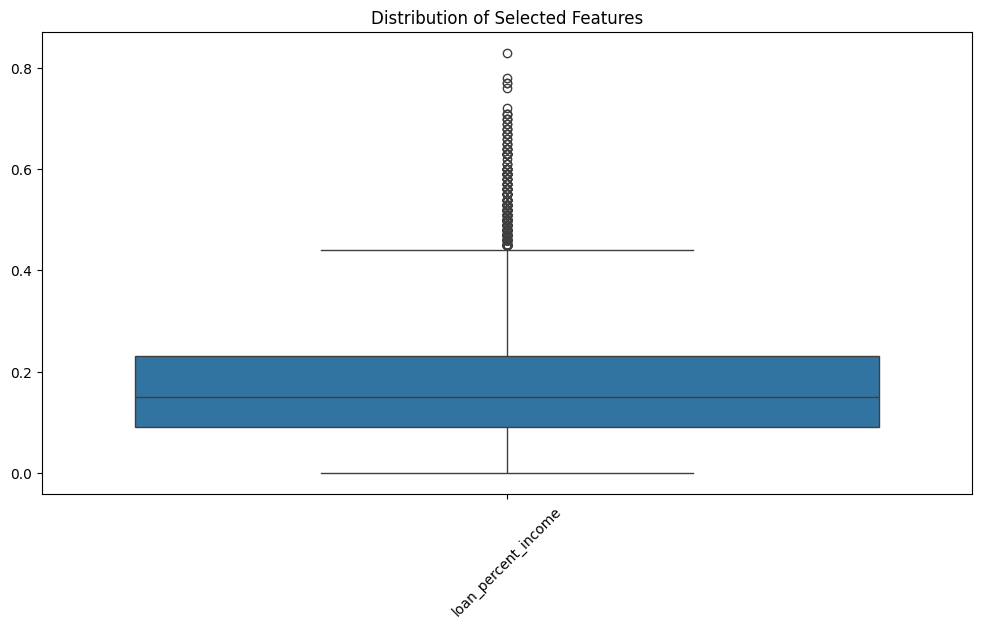

In [7]:
cols = ['loan_percent_income']
df_selected = df[cols]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_selected)
plt.title('Distribution of Selected Features')
plt.xticks(rotation=45)
plt.show()

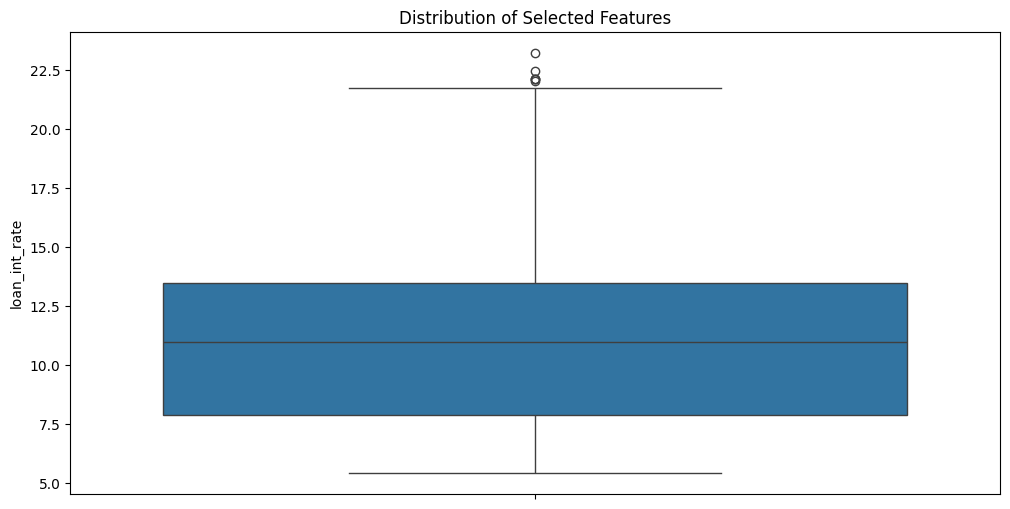

In [8]:
cols = 'loan_int_rate'
df_selected = df[cols]

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_selected)
plt.title('Distribution of Selected Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Ok so now we have dealt with our outliers let's see the distribution of our categorical columns

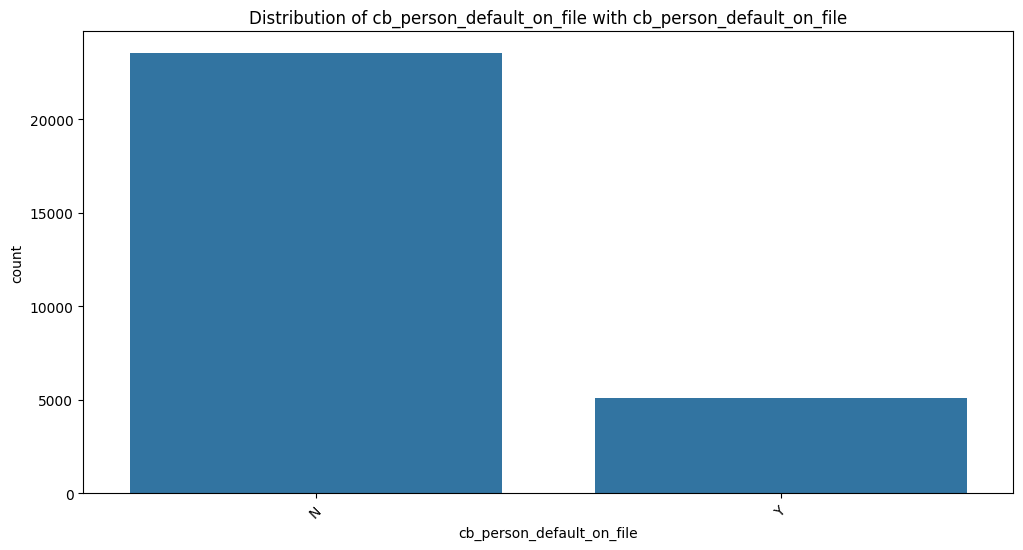

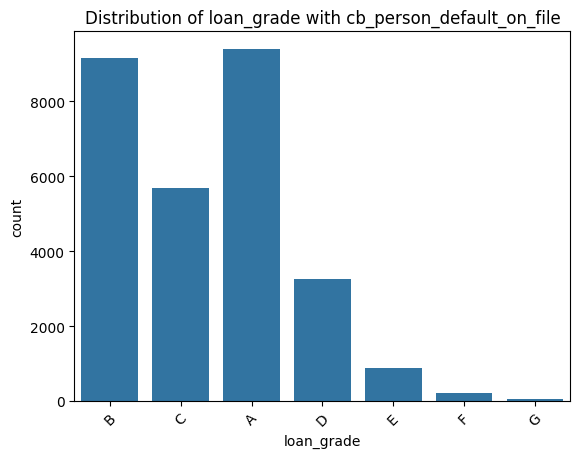

In [9]:
# prompt: I need a bar graph to see a distribution of cb_person_default_on_file,loan_grade
# Create the bar plot
plt.figure(figsize=(12, 6))
cols_to_plot = ['cb_person_default_on_file', 'loan_grade']
for col in cols_to_plot:
    sns.countplot(x=col, data=df) #hue for the second variable
    plt.title(f'Distribution of {col} with cb_person_default_on_file')
    plt.xticks(rotation=45)
    plt.show()


## 3. Baseline Model

In [10]:
base_acc = round(df['loan_status'].value_counts(normalize=True)*100, 2).max()
print(f'The baseline accuracy is {base_acc}%')

The baseline accuracy is 78.33%


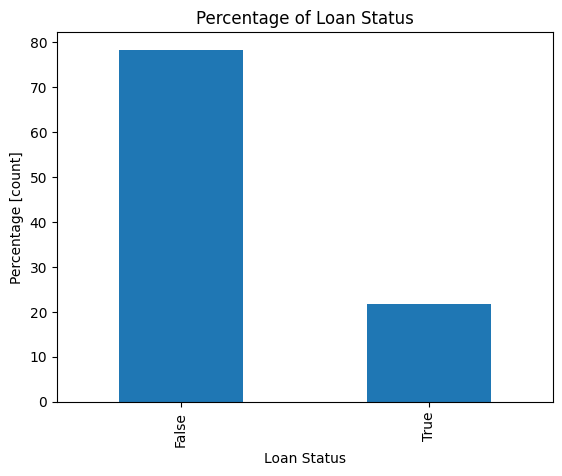

In [11]:
(df['loan_status'].value_counts(normalize=True)*100).plot(kind='bar')

plt.xlabel('Loan Status')
plt.ylabel('Percentage [count]')
plt.title('Percentage of Loan Status')
plt.show()

Now this is a bit troubling because our data is imbalanced which means we have to use sampling methods to make sure our data is properly balanced.

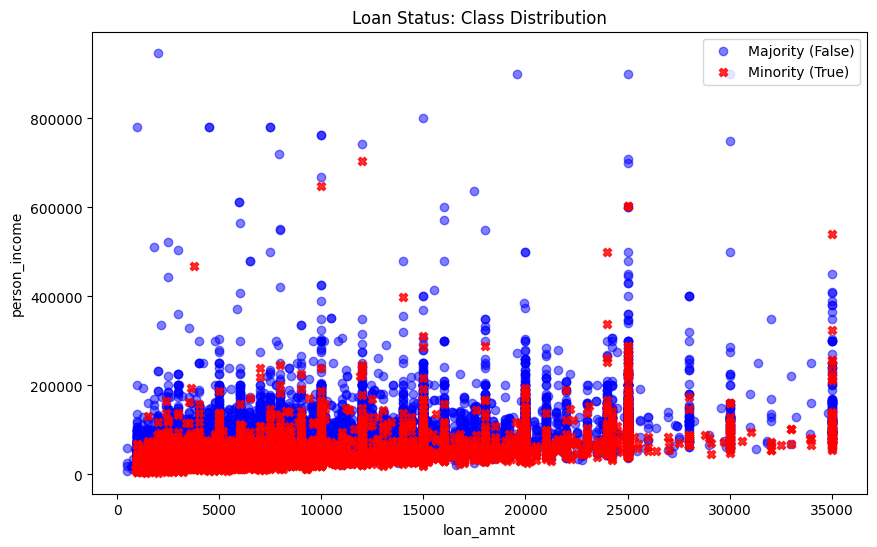

In [12]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and features are numeric
plt.figure(figsize=(10, 6))
# Select features for x and y axes (replace 'feature1', 'feature2' with actual column names)
feature1 = 'loan_amnt'
feature2 = 'person_income'

plt.scatter(
    df.loc[df['loan_status'] == 0, feature1],  # Majority class (False)
    df.loc[df['loan_status'] == 0, feature2],
    color='blue', label='Majority (False)', alpha=0.5
)
plt.scatter(
    df.loc[df['loan_status'] == 1, feature1],  # Minority class (True)
    df.loc[df['loan_status'] == 1, feature2],
    color='red', label='Minority (True)', alpha=0.8, marker='X'
)
plt.xlabel(feature1)  # Label x-axis with the feature name
plt.ylabel(feature2)  # Label y-axis with the feature name
plt.legend()
plt.title('Loan Status: Class Distribution')
plt.show()

## 4.Building the Model

In [13]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22900, 11), (5725, 11), (22900,), (5725,))

In [14]:
lr_model = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SMOTE(random_state=42),
    LogisticRegression()
)

In [15]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression())])

### 4.2 Model Evalutation


In [16]:
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)
print(f'Accuracy Score for training set {round(accuracy_score(y_train, y_train_pred)*100, 2)}%')
print(f'Accuracy Score for test set {round(accuracy_score(y_test, y_test_pred)*100, 2)}%')

Accuracy Score for training set 78.51%
Accuracy Score for test set 79.04%


The model is actually doing good for both the training and the test dataset. However the aim is to get at least 95% percent accuracy score. I will try using ensemble methods and see.

### 5.2 Ensemble Models

In [17]:
rf_model = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42)
)

rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print(f'Random Forest Accuracy Score for training set {round(accuracy_score(y_train, y_train_pred_rf)*100, 2)}%')
print(f'Random Forest Accuracy Score for test set {round(accuracy_score(y_test, y_test_pred_rf)*100, 2)}%')


Random Forest Accuracy Score for training set 100.0%
Random Forest Accuracy Score for test set 89.59%


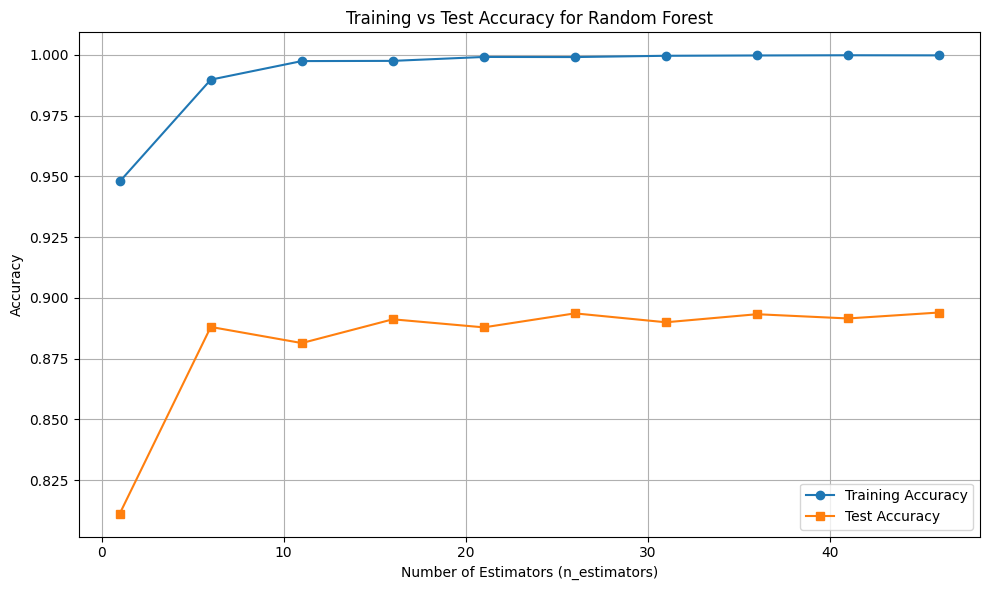

In [18]:
# Range of estimators to test
n_estimators_range = range(1, 50, 5)
train_accuracies = []
test_accuracies = []

for n in n_estimators_range:
    # Define the pipeline with current n_estimators
    model = make_pipeline(
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        SMOTE(random_state=42),
        RandomForestClassifier(n_estimators=n, random_state=42)
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and record accuracy
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
gb_model = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    SMOTE(random_state=42),
    GradientBoostingClassifier()
)

gb_model.fit(X_train, y_train)

y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

In [20]:
print(f'Random Forest Accuracy Score for training set {round(accuracy_score(y_train, y_train_pred_gb)*100, 2)}%')
print(f'Random Forest Accuracy Score for test set {round(accuracy_score(y_test, y_test_pred_gb)*100, 2)}%')

Random Forest Accuracy Score for training set 91.0%
Random Forest Accuracy Score for test set 87.63%


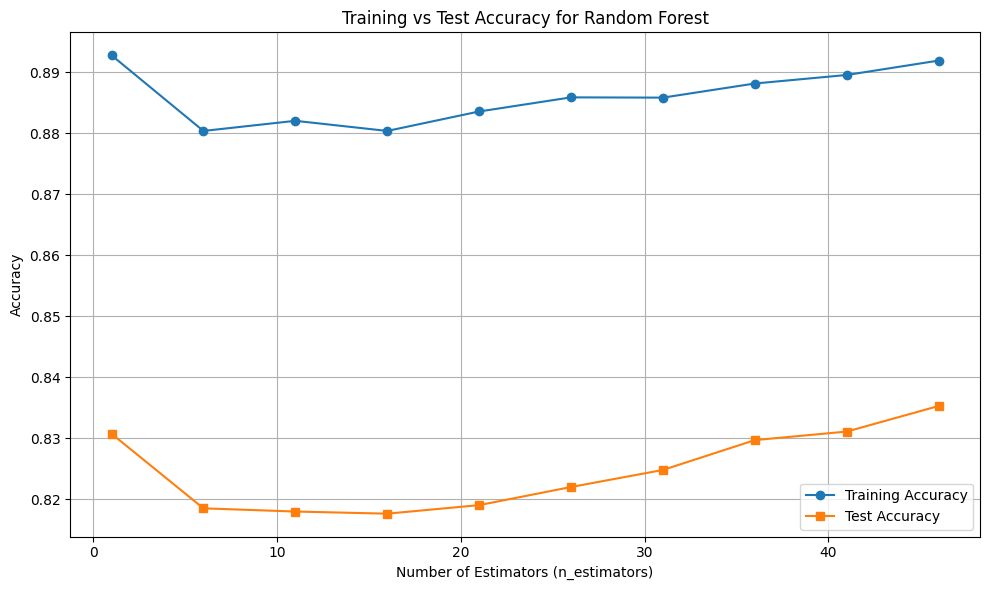

In [21]:
# Range of estimators to test
n_estimators_range = range(1, 50, 5)
train_accuracies = []
test_accuracies = []

for n in n_estimators_range:
    # Define the pipeline with current n_estimators
    model = make_pipeline(
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        SMOTE(random_state=42),
        GradientBoostingClassifier(n_estimators=n, random_state=42)
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and record accuracy
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_accuracies.append(accuracy_score(y_train, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
final_model = make_pipeline(
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        SMOTE(random_state=42),
        GradientBoostingClassifier(n_estimators=2, random_state=42)
    )

    # Fit the model
final_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('smote', SMOTE(random_state=42)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=2, random_state=42))])

In [23]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

print(f'Random Forest Accuracy Score for training set {round(accuracy_score(y_train, y_train_pred)*100, 2)}%')
print(f'Random Forest Accuracy Score for test set {round(accuracy_score(y_test, y_test_pred)*100, 2)}%')

Random Forest Accuracy Score for training set 89.28%
Random Forest Accuracy Score for test set 83.07%


In [24]:
pk.dump(final_model, open('model.pkl', 'wb'))


In [25]:
model = pk.load(open('model.pkl', 'rb'))

In [30]:
# prompt: Please make a dictionary and come up with your own values and pass this dictionary into the model to see what it will predict. Don't include the loan status column since that's what we're trying to predict

import pandas as pd
import pickle as pk

# Load the trained model
model = pk.load(open('model.pkl', 'rb'))

# Create a dictionary with sample data (exclude 'loan_status')
new_data = {
    'person_age': 21,
    'person_income': 9600,
    'person_home_ownership': 'OWN',
    'person_emp_length': 5,
    'loan_intent': 'EDUCATION',
    'loan_grade': 'B',
    'loan_amnt': 1000,
    'loan_int_rate': 11.14,
    'loan_percent_income': 0.1,
    'cb_person_default_on_file': 'N',
    'cb_person_cred_hist_length': 2
}

# Convert the dictionary to a DataFrame
new_df = pd.DataFrame([new_data])

# Make a prediction
prediction = model.predict(new_df)
print(f"Prediction: {prediction[0]}")  # Access the prediction from the array


Prediction: True
